In [1]:
# 가격 예측 - 회귀
# 보스턴지역의 외각의 주택가격및 가격과 함께 제공되는 정보를 가지고 주택 가격의 중간 값을 예측

In [2]:
from keras.datasets import boston_housing
(train_data,train_target),(test_data,test_target) =  boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [5]:
train_data.shape, train_target.shape

((404, 13), (404,))

In [7]:
train_target[:10] # 만달러 ~ 오만달러 1970년대 중반 - 인플레이션에 영향을 안받았다.

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

In [12]:
# 데이터의 특성이 다양하고 다르면.. 입력 데이터에 있는 각 특성(피처, 열)에 대해서 평균을 빼고 표준편차로 나눕니다.
# 특성의 중앙이 0근처에 맞춰지고 표준편차가 1이 됩니다. 
mean =  train_data.mean(axis = 0) # 열을 기준
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

# 머신러닝에서 절대로.. 테스트 데이터 어떠한 계산한 값을 사용해서는 안됨 그래서 아래와 같이 훈련데이터의 평균과 표준편차를 이용해서 정규화
test_data -= mean
test_data /= std

In [13]:
train_data.shape

(404, 13)

In [14]:
from keras import models
from keras import layers
# 동일한 모델을 여러변 생성하기위해서 함수로 작성합니다. - 모델생성
def make_model():
  model = models.Sequential();
  model.add(layers.Dense(64, activation='relu', input_shape = (13,)))
  model.add(layers.Dense(64,activation='relu' ))
  model.add(layers.Dense(1))  # 선형층
  model.compile(optimizer='rmsprop', loss = 'mse', metrics=['mae'])
  return model

In [20]:
# k-fold 검증
import numpy as np
k = 4
num_val_samples =  len(train_data) // k
num_epochs = 100
all_score = []
for i in range(k):
  print("current fold :", i)
  #검증데이터
  val_data =  train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_target = train_target[i*num_val_samples:(i+1)*num_val_samples]
  #훈련데이터
  partial_train_data =  np.concatenate( [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_target =  np.concatenate( [train_target[:i*num_val_samples], train_target[(i+1)*num_val_samples:]], axis=0)

  #케라스 모델
  model = make_model();
  model.fit(partial_train_data,partial_train_target,epochs=num_epochs, batch_size=1, verbose=0)
  # 검증세트로 평가
  val_mse, val_mae =  model.evaluate(val_data, val_target, verbose=0)
  all_score.append(val_mae)

current fold : 0
current fold : 1
current fold : 2
current fold : 3


In [21]:
all_score

[2.218676805496216, 2.4274837970733643, 2.8471486568450928, 2.4886584281921387]

In [22]:
np.mean(all_score)

2.495491921901703

In [24]:
 # k-fold 검증
from keras import backend as k
# 메모리 해제
k.clear_session()

k = 4
num_val_samples =  len(train_data) // k
num_epochs = 500
all_mae_histories = []
all_score = []
for i in range(k):
  print("current fold :", i)
  #검증데이터
  val_data =  train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_target = train_target[i*num_val_samples:(i+1)*num_val_samples]
  #훈련데이터
  partial_train_data =  np.concatenate( [train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_target =  np.concatenate( [train_target[:i*num_val_samples], train_target[(i+1)*num_val_samples:]], axis=0)

  #케라스 모델
  model = make_model();
  history =  model.fit(partial_train_data,partial_train_target
                       ,validation_data=(val_data, val_target)
                       ,epochs=num_epochs, batch_size=1, verbose=0)  
  
  all_mae_histories.append(history.history['val_mae'])
  # 검증세트로 평가 - 위의 결과로 대체
  #val_mse, val_mae =  model.evaluate(val_data, val_target, verbose=0)
  #all_score.append(val_mae)

current fold : 0
current fold : 1
current fold : 2
current fold : 3


In [27]:
 average_mae_hisotry =  [np.mean( [ x[i] for x in all_mae_histories] ) for i in range(num_epochs)  ]

No handles with labels found to put in legend.


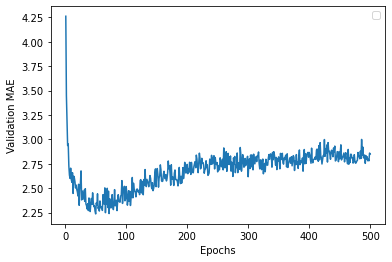

In [29]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_hisotry)+1), average_mae_hisotry)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

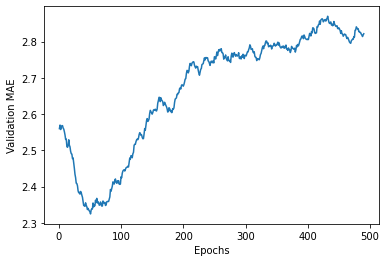

In [31]:
# 곡선의 다른부분과 스케일이 많이 다른 첫 10개 포인트를 제거
# 부드러운 곡선을 각 포인트를 이전 포인트의 지수 이동평균으로 대체
def smooth_curve(points, factor = 0.9):
  smoth_point = []
  for point in points:
    if smoth_point:
      previous = smoth_point[-1];
      smoth_point.append(previous*factor+ point *(1-factor))
    else:
      smoth_point.append(point)
  return smoth_point

smoth_mae_history = smooth_curve(average_mae_hisotry[10:])
plt.plot(range(1,len(smoth_mae_history)+1), smoth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [33]:
np.argmin( smoth_mae_history)

50

In [46]:
from keras import backend as K
K.clear_session()
model = make_model()
model.fit(train_data, train_target,epochs=80, batch_size=16,verbose=0)
test_mse_score, test_mae_score =  model.evaluate(test_data,test_target)
          

4/4 [==============================] - 0s 3ms/step - loss: 5614107.5000 - mae: 2309.3152


In [45]:
test_mae_score, test_mse_score

(2816.0263671875, 8327912.0)